# Описание проекта

**Вместе с отделом маркетинга подготовилен список гипотез для увеличения выручки.
В этом проекте мы приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.** 

## Загрузим необходимые для работы библиотеки, посмотрим данные датасет на наличие пропусков и соответствия типов данных.

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt

**Датасет Orders:**

In [2]:
orders = pd.read_csv('/datasets/orders.csv')
orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace = True )
# orders.info()

#приведение к нужному типу данных
orders['date'] = orders['date'].astype('datetime64[D]')
orders.info()
orders.head(5)

#пропуски
orders.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

**Датасет Visitors:**

In [3]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()

#приведение к нужному типу данных
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors.info()
visitors.head(5)

#пропуски
visitors.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


date        0
group       0
visitors    0
dtype: int64

### Вывод:
В данных датасетах пропуски не обнаружены. В датасете Orders были стандартизированы имена стобцов, столбец с датой был приведён к типу datetime. В датасете Visitors была проделана такая же работы.
Данные, представленные в наших датасетах:

 **Orders**:
- transaction_id — идентификатор заказа;
- visitor_id — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ. 

**Visitors:**
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста**

## Часть 1. Приоритизация гипотез.

In [4]:
hyp = pd.read_csv('/datasets/hypothesis.csv')
hyp.rename(columns = {'Hypothesis':'hypothesis', 
                      'Reach':'reach',
                      'Impact':'impact',
                      'Confidence':'confidence',
                     'Efforts':'efforts'}, inplace = True )

hyp['hypothesis'].unique()

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

### Приоритизация гипотез методом ICE:

In [5]:
hyp['ice'] = round((hyp['impact'] * hyp['confidence'] / hyp['efforts']),2)
hyp.sort_values(by='ice', ascending =False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00


### Приоритизация гипотез методом RICE:

In [6]:
hyp['rice'] = (hyp['reach'] * hyp['impact'] * hyp['confidence']) / hyp['efforts']
hyp.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.0


### Выводы по приоритизации гипотез методами ICE и RICE:

- По фреймворку ICE наибольшую оценку имели гипотезы 8, 0 и 7. 
- После применения фреймворка RICE приоритеты изменились на гипотезы 7, 2 и 0.

**Это объясняется тем, что в случае фреймворка ICE в отличие от RICE мы не учитывали охват изменений, а это важная составляющая оценки гипотез.**

- Отдадим приоритет гипотезам:
    - 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок';
    - 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа';
    - 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'.

## Часть 2. Анализ A/B-теста

**Проверим корректность распределения на группы A/B**

- Проверим размеры групп в выборке, есть ли разница между ними
- Проверим, корректно ли был рассчитан размер выборки для проведения теста

In [7]:
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))

results = stats.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

initial_conversion = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
resulting_conversion = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()
print('Начальная конверсия: {:.3f}'.format(initial_conversion))
print('Полученная после изменений конверсия: {:.3f}'.format(resulting_conversion))
print('Относительное изменение конверсии после изменений: {:.3f}'.format(abs(1-(initial_conversion/resulting_conversion))))
print('\nВводим начальную конверсию и полученное относительное изменение конверсии в калькулятор\n'
     'Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html\n'
     'Получаем необходимое количество выборки 35855 для корректного проведения тестирования\n'
     'В нашем случае количество посещений: {} \n'
      'Кол-во выборки для A/B тестирования корректно подобрано, ' 
      'статистически значимой разницы\nв количестве посещений м/у группами не обнаружено\n'.format(visitors['visitors'].sum()))

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640
P-value:0.7301376549390499
Разница в количестве посетителей в группах A и B статистически НЕ значима

Начальная конверсия: 0.030
Полученная после изменений конверсия: 0.034
Относительное изменение конверсии после изменений: 0.121

Вводим начальную конверсию и полученное относительное изменение конверсии в калькулятор
Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html
Получаем необходимое количество выборки 35855 для корректного проведения тестирования
В нашем случае количество посещений: 37652 
Кол-во выборки для A/B тестирования корректно подобрано, статистически значимой разницы
в количестве посещений м/у группами не обнаружено



### Построим график кумулятивной выручки по группам.

In [8]:
orders.drop(len(np.intersect1d(orders.query('group == "A"')['visitor_id'], orders.query('group == "B"')['visitor_id'], assume_unique=False)))

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [9]:
# уникальные значения дат и групп
date_groups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])

#выводим кумулятивные показатели из orders
orders_aggregat = date_groups.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'], x['group']==orders['group'])]\
.agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis = 1)
orders_aggregat.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

#выводим кумулятивные показатели из visitors
visitors_aggregat = date_groups.apply(lambda x: visitors[np.logical_and(x['date'] >= visitors['date'], x['group']==visitors['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)

#сводим все накопительные данные в одну таблицу
cummulative_data = orders_aggregat.merge(visitors_aggregat, left_on=['date', 'group'], right_on=['date', 'group'])

cummulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


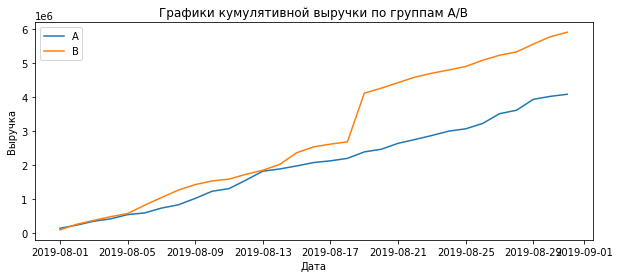

In [10]:
cummulative_data_a = cummulative_data[cummulative_data['group']=='A']
cummulative_data_b = cummulative_data[cummulative_data['group']=='B']
plt.figure(figsize=(10,4))
plt.plot(cummulative_data_a['date'], cummulative_data_a['revenue'], label = 'A')
plt.plot(cummulative_data_b['date'], cummulative_data_b['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend()
plt.show()


*Вывод*:

<span style="color:red">Группа B стабильно показывает большую выручку, чем группа A.</span>


### Построим график кумулятивного среднего чека по группам

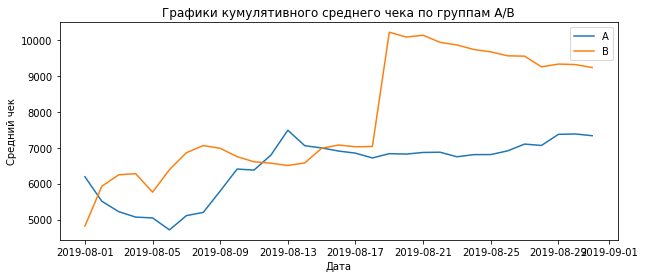

In [11]:
plt.figure(figsize=(10,4))
plt.plot(cummulative_data_a['date'], cummulative_data_a['revenue']/cummulative_data_a['orders'], label = 'A')
plt.plot(cummulative_data_b['date'], cummulative_data_b['revenue']/cummulative_data_b['orders'], label = 'B')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show()


*Вывод*:

<span style="color:red">Как мы видим, средний чек в группе B почти всё время был выше, но нас должно смутить его резкое колебание во второй половине графика, есть вероятность, что это обусловлено аномалиями.</span>

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

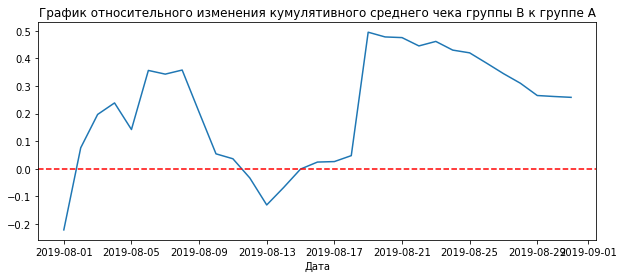

In [12]:
merge_сummulative_data = cummulative_data_a.merge(cummulative_data_b, left_on='date', right_on='date', suffixes=['A', 'B'])
# merge_сummulative_data.head(5)
plt.figure(figsize=(10,4))
plt.plot(merge_сummulative_data['date'], ((merge_сummulative_data['revenueB']/merge_сummulative_data['ordersB'])/
                                       (merge_сummulative_data['revenueA']/merge_сummulative_data['ordersA'])-1))
plt.axhline(y=0, color='red', linestyle = '--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.show()


*Вывод:*

<span style="color:red">Как мы и говорили - колебания слишком резкие, необходимо будет проверить данные на наличие аномальных пользователей.</span>

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

**Построим график кумулятивной конверсии по группам**

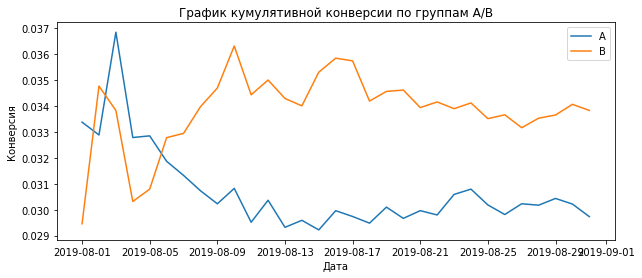

In [13]:
merge_сummulative_data['conversionA'] =  merge_сummulative_data['ordersA'] / merge_сummulative_data['visitorsA'] 
merge_сummulative_data['conversionB'] =  merge_сummulative_data['ordersB'] / merge_сummulative_data['visitorsB']
# merge_сummulative_data.head(5)

plt.figure(figsize=(10,4))
plt.plot(merge_сummulative_data['date'], merge_сummulative_data['conversionA'], label='A')
plt.plot(merge_сummulative_data['date'], merge_сummulative_data['conversionB'], label='B')
plt.title('График кумулятивной конверсии по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()


*Вывод:*

<span style="color:red">Группа B стабильно показывает большую конверсию чем группа A.</span>

### Построим график относительного изменения кумулятивной конверсии группы B к группе A

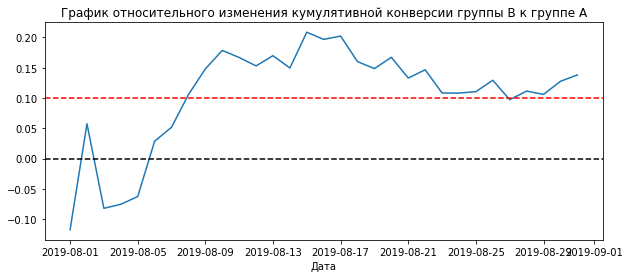

In [14]:
# merge_сummulative_data.head(5)
plt.figure(figsize=(10,4))
plt.plot(merge_сummulative_data['date'], ((merge_сummulative_data['conversionB']/merge_сummulative_data['conversionA'])-1))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.xlabel('Дата')
plt.show()


*Вывод:*

<span style="color:red">Конверсия в группе B стабильно лучше конверсии в группе A на 10% через 1 неделю после начала.</span>

### Построим точечный график количества заказов по пользователям.

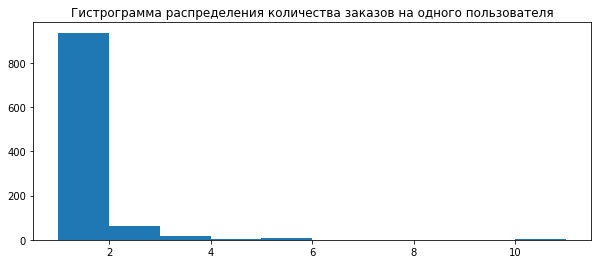

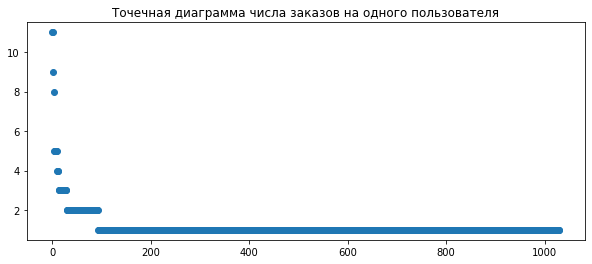

In [15]:
orders.head(5)
orders_by_users = (
    orders.groupby('visitor_id', as_index = False)
    .agg({'transaction_id':'nunique'})
    .sort_values(by='transaction_id', ascending = False)
)
orders_by_users.columns = ['visitor_id', 'orders']
# orders_by_users.head(5)

plt.figure(figsize=(10,4))
plt.hist(orders_by_users['orders'], bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()

x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()


*Вывод:*

<span style="color:red">На графиках видно,что подавляющее большинство пользователей не совершает более 2 заказов.</span>

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [16]:
percentiles = np.percentile(orders_by_users['orders'], [95, 99])
print('Перцентили:\n95: {}\n99: {}'.format(percentiles[0],percentiles[1]))


Перцентили:
95: 2.0
99: 4.0


*Вывод:*

<span style="color:red">Как мы и предполагали, больше 2 заказов совершают только 5% пользователей.</span>


### Построим точечный график стоимостей заказов.

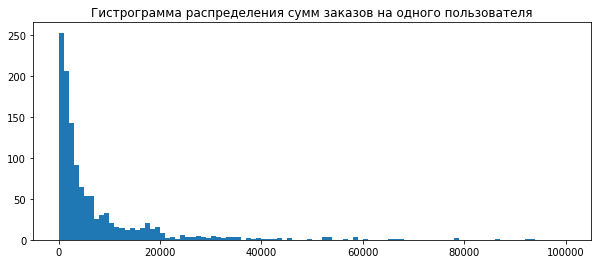

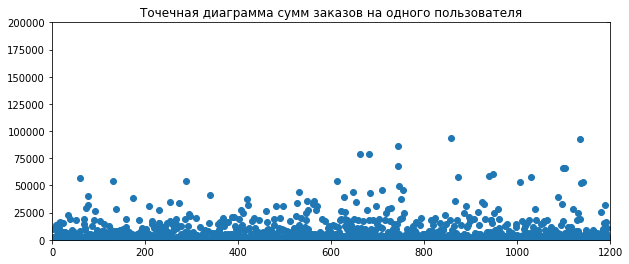

In [17]:
plt.figure(figsize=(10,4))
plt.hist(orders['revenue'], range=(0,100000), bins = 100)
plt.title('Гистрограмма распределения сумм заказов на одного пользователя')
plt.show()

x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.show()

*Вывод:*

<span style="color:red">Судя по графикам, большая часть пользователей делает покупки суммой не больше 25-30 т.р.</span>

### Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [18]:
percentiles = np.percentile(orders['revenue'], [95, 99])
print('Перцентили:\n95: {:.0f}\n99: {:.0f}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 28000
99: 58233


*Вывод:*

<span style="color:red">Всего лишь 5% заказов дороже 28 т.р.</span>

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

**Сформулируем нулевую и альтернативную гипотезу:**

- `H₀`: По "сырым" данным в конверсии групп A и B разница статистически значима.
- `H₁`: По "сырым" данным различий в конверсии групп A и B нет.

In [19]:
orders_by_users_a = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_a.columns = ['visitor_id', 'orders']
orders_by_users_b = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_b.columns = ['visitor_id', 'orders']
print('Кол-во покупателей в группе A: {}'.format(len(orders_by_users_a)))
print('Кол-во покупок в группе А: {}'.format(orders_by_users_a['orders'].sum()))
print('Кол-во посетителей в группе A: {}\n'.format(visitors[visitors['group']=='A']['visitors'].sum()))
print('Кол-во покупателей в группе B: {}'.format(len(orders_by_users_b)))
print('Кол-во покупок в группе B: {}'.format(orders_by_users_b['orders'].sum()))
print('Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='B']['visitors'].sum()))


#составим списки кол-ва заказов sampleA и sampleB со всеми пользователями (в том числе и не купившими) по группам 
list_orders_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(orders_by_users_a))):
    list_orders_1.append(0)
orders_by_non_purchased_users_a = pd.Series(data = list_orders_1, name = 'orders')

list_orders_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(orders_by_users_b))):
    list_orders_2.append(0)
orders_by_non_purchased_users_b = pd.Series(data = list_orders_2, name = 'orders')

sampleA = pd.concat([orders_by_users_a['orders'], orders_by_non_purchased_users_a], axis=0)
sampleB = pd.concat([orders_by_users_b['orders'], orders_by_non_purchased_users_b], axis=0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))

alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB)
print('P-value: {}'.format(results.pvalue))

if results.pvalue < alpha:
    print('По "сырым" данным в конверсии групп A и B разница статистически значима!')
else:
    print('По "сырым" данным различий в конверсии групп A и B нет!')

Кол-во покупателей в группе A: 503
Кол-во покупок в группе А: 557
Кол-во посетителей в группе A: 18736

Кол-во покупателей в группе B: 586
Кол-во покупок в группе B: 640
Кол-во посетителей в группе B: 18916

Относительный прирост конверсии группы B по отношению к группе A: 0.138
P-value: 0.016792355056752608
По "сырым" данным в конверсии групп A и B разница статистически значима!


### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

**Сформулируем нулевую и альтернативную гипотезу:**

- `H₀`: По "сырым" данным разница в средних чеках в группах A и B статистически значима..
- `H₁`: По "сырым" данным различий в средних чеках в группах A и B нет.

In [20]:
print('Относительное изменение среднего чека в группе B по отношению группы A: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value: {}'.format(results.pvalue))

if results.pvalue < alpha:
    print('По "сырым" данным разница в средних чеках в группах A и B статистически значима.')
else:
    print('По "сырым" данным различий в средних чеках в группах A и B нет.')

Относительное изменение среднего чека в группе B по отношению группы A: 0.259
P-value: 0.7292909855432458
По "сырым" данным различий в средних чеках в группах A и B нет.


### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

**Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным**

<span style="color:#191970">Ранее мы узнали, что большинство пользователей делает не более 2 заказов и сумма одной покупки в большинстве случаев не превышает 28 т.р.
    Очистим данные от аномальных пользователей с превышающими данные лимиты значениями.</span>


In [21]:
#зададим предельные кол-во заказов и сумму покупки для формирования списка аномальных пользователей
limit_orders = 2
limit_revenue = 28000

In [22]:
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders']>limit_orders]['visitor_id'], 
                                orders_by_users_b[orders_by_users_b['orders']>limit_orders]['visitor_id']], axis = 0)

users_with_expensive_orders = orders[orders['revenue']>limit_revenue]['visitor_id']

ab_normal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0).drop_duplicates().sort_values()

print('Кол-во аномальных пользователей: {}'.format(len(ab_normal_users)))

Кол-во аномальных пользователей: 74


In [23]:
sample_a_filtered = pd.concat([
    orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(ab_normal_users))]['orders'],
    orders_by_non_purchased_users_a
], axis = 0)
sample_b_filtered = pd.concat([
    orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(ab_normal_users))]['orders'],
    orders_by_non_purchased_users_b
], axis = 0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A после очистки данных: {:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

results = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)
print('P-value: {}'.format(results.pvalue))

if results.pvalue < alpha:
    print('По очищенным данным в конверсии групп A и B разница статистически значима!')
else:
    print('По очищенным данным различий в конверсии групп A и B нет!')


Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.173
P-value: 0.013042592743036745
По очищенным данным в конверсии групп A и B разница статистически значима!


### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

**Сформулируем нулевую и альтернативную гипотезу:**

- `H₀`: По очищенным данным разница в средних чеках в группах A и B статистически значима.
- `H₁`: По очищенным данным различий в средних чеках в группах A и B нет.

In [24]:
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(ab_normal_users)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(ab_normal_users)))]['revenue'].mean()-1))
       
       
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(ab_normal_users)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(ab_normal_users)))]['revenue'])
print('P-value: {}'.format(results.pvalue))

if results.pvalue < alpha:
    print('По очищенным данным разница в средних чеках в группах A и B статистически значима!')
else:
    print('По очищенным данным различий в средних чеках в группах A и B нет!')

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.020
P-value: 0.738481751314565
По очищенным данным различий в средних чеках в группах A и B нет!


### Примем решение по результатам теста:

- **Варианты принимаемых решений:**
    * *Остановить тест, зафиксировать победу одной из групп.*
    * *Остановить тест, зафиксировать отсутствие различий между группами.*
    * *Продолжить тест.*

Выборка данных имеет корректный размер, проблему подглядывания в результате сравнения групп во время проведения теста мы `исключили`.
Кумулятивные метрики по выручке, среднему чеку и конверсии почти все время лидировали `в группе B`.
До очистки данных от аномальных пользователей были резкие колебания на графике кумулятивного среднего чека `в группе B`.
После очистки` разница между средними чеками стала минимальна`, но это не даёт нам повода сомневаться в проведении теста и его результатах. 
До и после очистки данных, `показатель конверсии в группе B больше показателя в группе A`. Данная разница показателей конверсии между группами и до и после очистки данных является `статистически значимой`, что позволяет нам сделать вывод о том, что мы можем `остановить наш A/B тест` и `зафиксировать победу группы B`.
